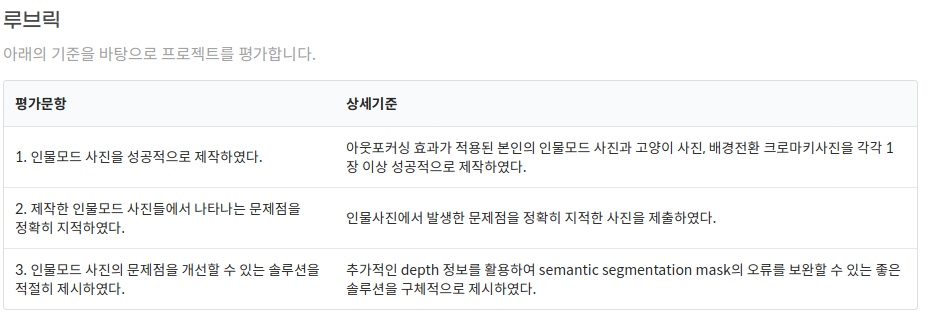

1. 인물모드 사진을 성공적으로 제작하였다.       
 yes!ㅎ 고양이, 제 사진, 배경전환을 하였습니다. 

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.       
    지적은 하였습니다!ㅎ
    
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다. 
    솔루션은 넣었는데 적절한지는 루브릭수로 알려주세요! 

# 인물사진을 만들어 보자!
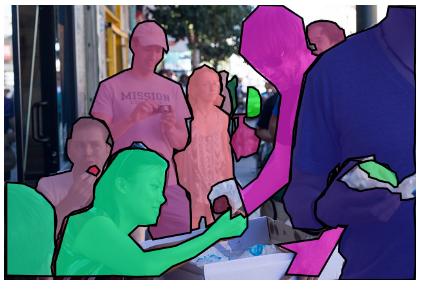

In [ ]:
#모듈을 불러와 봅시다!

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join 
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [ ]:
#데이터 불러오기 

In [3]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/minje.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2944, 2208, 3)


# 10-3. 셸로우 포커스만들기
(2) 세그멘테이션으로 사람 분리하기 

이제 누끼따기!를 해보도록 하겠습니다! 

세그멘테이션: 관심 객체를 추출하는 것을 의미합니다. 
인스턴스 세그멘테이션: 같은 라벨을 갖더라도 다르게 분류를 가능하게 합니다. 

웨터세드 세그멘테이션: 이미지 세그멘테이션의 간단한 알고리즘

이미지 영역을 분할하는 가장 간단한 방법이 물체의 '경계'를 나누는 겁니다. 

경계를 나누는 방법은 그레이스케일로 변환하고 엣지를 찾습니다. 

우리의 모델은 DeepLab알고리즘 모델이 성능이 좋으니 이걸 사용하도록 하죠!


In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac11/aiffel/human_segmentation/models
model loaded successfully!


In [7]:
#이미지 네트워크 준비하기 

In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2944, 2208, 3) (513, 384, 3) 15


In [8]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

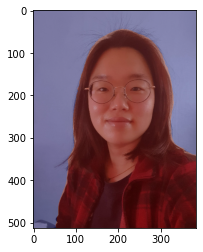

In [10]:
#이미지 세그멘테이션 결과를 확인하자!
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
#이미지 사이즈 복원하기 

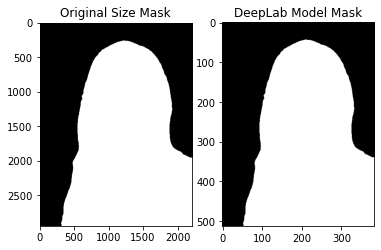

In [12]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

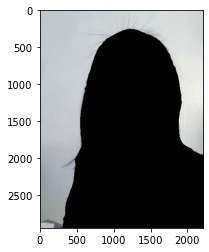

In [13]:
#배경 흐리게 만들기 

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

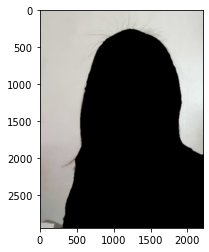

In [15]:
#이미지 블러처리하기 
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

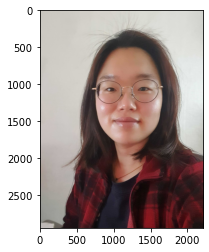

In [16]:
#흐린배경에 원본 영상 합성하기 
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

첫번째 이미지는 음 뒷배경이 아무것도 없어서 괜찮은 것 같네요! 

문제가 없어보여요! 다음에 이미지를 찍는다면 하얀 배경에 찍어야겠네요ㅎ

다른 이미지를 첨부해보도록 하겠습니다. 

In [17]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/minjes.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 

In [19]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(720, 960, 3) (384, 513, 3) 15


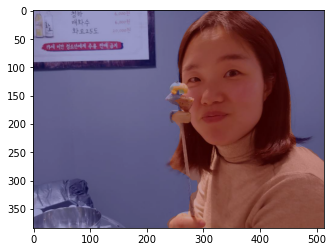

In [20]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

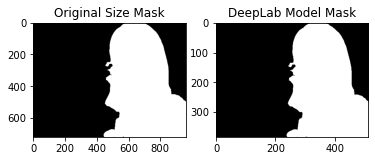

In [21]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

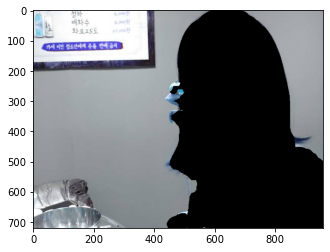

In [22]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

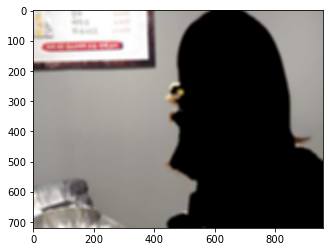

In [23]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

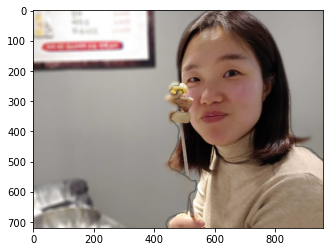

In [24]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
#스페인에 가고 싶어서 넣어봤어요ㅎ

In [27]:
background_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'
background_img_orig = cv2.imread(background_img_path) 

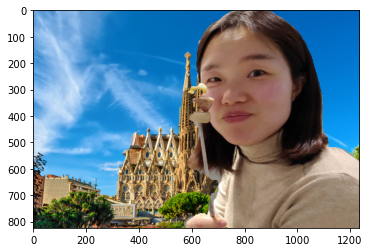

In [28]:

img_resized = cv2.resize(
    img_orig, (background_img_orig.shape[1], background_img_orig.shape[0]))
img_mask_resized = cv2.resize(
    img_mask_color, (background_img_orig.shape[1], background_img_orig.shape[0]))

img_background_concat = np.where(
    img_mask_resized == 255, img_resized, background_img_orig)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
#고양이를 불러올게요!
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.jpeg'
cat_img_orig = cv2.imread(cat_img_path) 

In [30]:
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(718, 634, 3) (513, 452, 3) 8


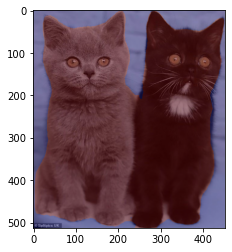

In [31]:
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0)
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()


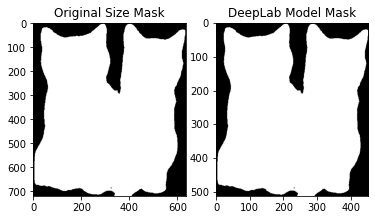

In [32]:

cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

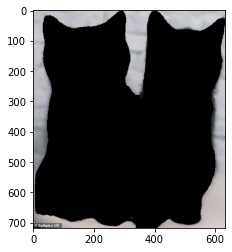

In [34]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, cat_img_bg_mask)
plt.imshow(cat_img_bg)
plt.show()

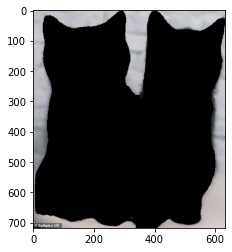

In [35]:
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, cat_img_bg_mask)
plt.imshow(cat_img_bg)
plt.show()


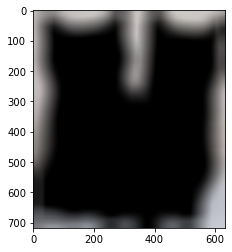

In [36]:

cat_img_bg_blur = cv2.blur(cat_img_bg, (70,70))
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

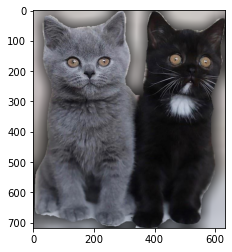

In [37]:

cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점

1. 누끼가 예쁘게 잘 안 따집니다! 테두리가 엉성해보이네요. 
2. 제 사진은 테두리가 까만 선이 생깁니다.  

고양이 2마리는 추출이 안될 줄 알았는데 다 되어서 너무 신기했습니다!ㅎ

# 해결책 

1. 누끼가 잘 안 따지는 이유는 배경라벨에 대한 이미지가 부족한 것은 아닐까?   
2. 이미지 처리에 대한 부분이 무궁무진해 보입니다. 
3. 깊이 영상을 활용하는 것도 방법이겠군요. 
4. 이미지를 다양한 각도에서 촬영하여 input데이터로 넣어줘도 좋겠네요. 
5. 적외선을 활용하는 방법도 있다고 합니다. 